# Import datasets

In [1]:
import os, json, dill
from load_params import load_parameters
from sindy_utils import *
import pysindy as ps
from sklearn.metrics import mean_squared_error
import warnings

# Temporarily suppress warnings
warnings.simplefilter("ignore", category=UserWarning)
print("=== BEWARE: Suppressing UserWarnings temporarily! ===\n")

PARAM_DIR = {'FOLDER': 'config', 'FILE': 'params.yaml'}
MODELS_DIR = {'FOLDER': 'models'}

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Split the path at 'scripts' and take the first part
pkg_dir = notebook_dir.split('scripts')[0]

# Define and create the directory to save the models
models_dir = os.path.join(pkg_dir, MODELS_DIR['FOLDER'])
os.makedirs(models_dir, exist_ok=True)

# Load parameters
param_file = os.path.join(pkg_dir, PARAM_DIR['FOLDER'], PARAM_DIR['FILE'])
params = load_parameters(param_file)

# Load the column names
with open(os.path.join(os.path.expanduser(params['DATASET_FOLDER']), params['COLUMN_NAMES_FILE']), 'r') as f:
    data = json.load(f)
conf_names = data["conf_names"]
conf_names_filt = data["conf_names_filt"]
conf_names_vel = data["conf_names_vel"]
conf_names_acc = data["conf_names_acc"]
conf_names_jerk = data["conf_names_jerk"]
param_names = data["param_names"]
kpt_names = data["kpt_names"]
kpt_names_filt = data["kpt_names_filt"]
kpt_names_vel = data["kpt_names_vel"]
kpt_names_acc = data["kpt_names_acc"]

# Load the datasets
if 'PICK-&-PLACE' in params['SELECTED_TASKS'].keys():
    train_df, test_df = load_dataset(
        params['DATASET_FOLDER'], params['DATASET_NAMES']['PICK-&-PLACE'],
        params['SELECTED_TASKS']['PICK-&-PLACE'], params['SELECTED_VELOCITIES'],
        params['TRAIN_SUBJECTS'], params['TEST_SUBJECTS']
    )

elif 'WALKING' in params['SELECTED_TASKS'].keys():
    train_df, test_df = load_dataset(
        params['DATASET_FOLDER'], params['DATASET_NAMES']['WALKING'],
        params['SELECTED_TASKS']['WALKING'], params['SELECTED_VELOCITIES'],
        params['TRAIN_SUBJECTS'], params['TEST_SUBJECTS']
    )

elif 'PASSING-BY' in params['SELECTED_TASKS'].keys():
    train_df, test_df = load_dataset(
        params['DATASET_FOLDER'], params['DATASET_NAMES']['PASSING-BY'],
        params['SELECTED_TASKS']['PASSING-BY'], params['SELECTED_VELOCITIES'],
        params['TRAIN_SUBJECTS'], params['TEST_SUBJECTS']
    )

else:
    raise ValueError("Selected task not found in the dataset names")

/home/nyquist/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


=== BEWARE: Suppressing UserWarnings temporarily! ===

dataset_PICK-&-PLACE.csv: TRAIN dataset shape: (157342, 369)
dataset_PICK-&-PLACE.csv: TEST dataset shape: (35031, 369)
dataset_PICK-&-PLACE.csv: TRAIN dataset shape after dropping NaNs: (157179, 369)
dataset_PICK-&-PLACE.csv: TEST dataset shape after dropping NaNs: (33948, 369)


# Define states and controls

In [2]:
selected_joints = None
selected_body_params = None
selected_kpts = None

if 'PICK-&-PLACE' in params['SELECTED_TASKS'].keys():
    print('Selected task: Pick & Place')
    selected_joints = params['PICKPLACE_BODY_JOINTS']
    selected_body_params = params['PICKPLACE_BODY_PARAMS']
    selected_kpts = [f'kp{i}_{dim}' for i in params['PICKPLACE_KPTS'] for dim in ['x', 'y', 'z']]

elif 'WALKING' in params['SELECTED_TASKS'].keys():
    print('Selected task: Walking')
    selected_joints = params['WALKING_BODY_JOINTS']
    selected_body_params = params['WALKING_BODY_PARAMS']
    selected_kpts = [f'kp{i}_{dim}' for i in params['WALKING_KPTS'] for dim in ['x', 'y', 'z']]

elif 'PASSING-BY' in params['SELECTED_TASKS'].keys():
    print('Selected task: Passing By')
    selected_joints = params['WALKING_BODY_JOINTS']
    selected_body_params = params['WALKING_BODY_PARAMS']
    selected_kpts = [f'kp{i}_{dim}' for i in params['WALKING_KPTS'] for dim in ['x', 'y', 'z']]

else:
    raise ValueError("Selected task not found in the dataset names")

conf_names      = [name for name in conf_names      if substring_in_list(name, selected_joints)]
conf_names_filt = [name for name in conf_names_filt if substring_in_list(name, selected_joints)]
conf_names_vel  = [name for name in conf_names_vel  if substring_in_list(name, selected_joints)]
conf_names_acc  = [name for name in conf_names_acc  if substring_in_list(name, selected_joints)]
conf_names_jerk = [name for name in conf_names_jerk if substring_in_list(name, selected_joints)]
param_names     = [name for name in param_names     if substring_in_list(name, selected_body_params)]
kpt_names       = [name for name in kpt_names       if substring_in_list(name, selected_kpts)]
kpt_names_filt  = [name for name in kpt_names_filt  if substring_in_list(name, selected_kpts)]
kpt_names_vel   = [name for name in kpt_names_vel   if substring_in_list(name, selected_kpts)]

print('Selected joints:', conf_names)
print('Selected body params:', selected_body_params)
print('Selected keypoints:', kpt_names)


# if params['ONLY_USE_UPPER_BODY']:
#     print('Using only upper body joints')

#     # Select joint coordinates in the upper body only
#     upper_body_frames = ['arm', 'elbow', 'head']
#     upper_body_kpts = ['0','1','2','3','4','5','6','7','14','15','16','17']

#     # Check if any of the upper_body_frames strings are substrings of the names in conf_names_*
#     def is_in_upper_body(name, list_of_names):
#         return any(item in name for item in list_of_names)

#     conf_names_upper = [name for name in conf_names if is_in_upper_body(name, upper_body_frames)]
#     conf_names_filt_upper = [name for name in conf_names_filt if is_in_upper_body(name, upper_body_frames)]
#     conf_names_vel_upper = [name for name in conf_names_vel if is_in_upper_body(name, upper_body_frames)]
#     conf_names_acc_upper = [name for name in conf_names_acc if is_in_upper_body(name, upper_body_frames)]
#     conf_names_jerk_upper = [name for name in conf_names_jerk if is_in_upper_body(name, upper_body_frames)]
#     kpt_names_upper = [name for name in kpt_names if is_in_upper_body(name, upper_body_kpts)]
#     kpt_names_filt_upper = [name for name in kpt_names_filt if is_in_upper_body(name, upper_body_kpts)]
#     kpt_names_vel_upper = [name for name in kpt_names_vel if is_in_upper_body(name, upper_body_kpts)]
#     kpt_names_acc_upper = [name for name in kpt_names_acc if is_in_upper_body(name, upper_body_kpts)]
    
#     conf_names = conf_names_upper
#     conf_names_filt = conf_names_filt_upper
#     conf_names_vel = conf_names_vel_upper
#     conf_names_acc = conf_names_acc_upper
#     conf_names_jerk = conf_names_jerk_upper
#     kpt_names = kpt_names_upper
#     kpt_names_filt = kpt_names_filt_upper
#     kpt_names_vel = kpt_names_vel_upper
#     kpt_names_acc = kpt_names_acc_upper

Selected task: Pick & Place
Selected joints: ['q_chest_rot_x', 'q_chest_rot_y', 'q_chest_rot_z', 'q_chest_rot_w', 'q_shoulder_rot_x', 'q_right_arm_rot_z', 'q_right_arm_rot_x', 'q_right_arm_rot_y', 'q_right_elbow_rot_z', 'q_left_arm_rot_z', 'q_left_arm_rot_x', 'q_left_arm_rot_y', 'q_left_elbow_rot_z', 'q_head_rot_z', 'q_head_rot_x']
Selected body params: ['shoulder_distance', 'chest_hip_distance', 'hip_distance', 'upper_arm_length', 'lower_arm_length', 'head_distance']
Selected keypoints: ['human_kp0_x', 'human_kp0_y', 'human_kp0_z', 'human_kp2_x', 'human_kp2_y', 'human_kp2_z', 'human_kp3_x', 'human_kp3_y', 'human_kp3_z', 'human_kp4_x', 'human_kp4_y', 'human_kp4_z', 'human_kp5_x', 'human_kp5_y', 'human_kp5_z', 'human_kp6_x', 'human_kp6_y', 'human_kp6_z', 'human_kp7_x', 'human_kp7_y', 'human_kp7_z']


In [3]:
# x: state -> q_ddot
# u: control -> q, q_dot, param
state_names = conf_names_acc
state_deriv_names = conf_names_jerk
control_names = []

if params['USE_CONF_FILT']:
    control_names += conf_names_filt
if params['USE_CONF_VEL']:
    control_names += conf_names_vel
if params['USE_PARAMS']:
    control_names += param_names
if params['USE_KPTS_FILT']:
    control_names += kpt_names_filt
if params['USE_KPTS_VEL']:
    control_names += kpt_names_vel

feature_names = state_names + control_names

# # Compute the correlation matrix
# train_corr = train_df[feature_names].corr()
# test_corr = test_df[feature_names].corr()

# # Plot the correlation matrix using plotly for the training and testing datasets
# plot_correlation_matrix(train_corr, 'Correlation Matrix - Training Data')
# plot_correlation_matrix(test_corr, 'Correlation Matrix - Testing Data')

# # Compute the KL divergence between the training and testing datasets for each feature.
# # The KL divergence is a measure of how much one probability distribution differs from a second, reference probability distribution.
# # A KL divergence of 0 indicates that the two distributions are identical
# for feature in feature_names:
#     kl_div = compute_kl_divergence(train_df[feature], test_df[feature])
#     print('KL Divergence for', feature, ':\t\t', kl_div)

# Exploratory Data Analysis (Visualization)

In [4]:
# import numpy as np

# # Retrieve data from the training dataset
# if 'PICK-&-PLACE' in params['SELECTED_TASKS'].keys():
#     instruction = params['SELECTED_TASKS']['PICK-&-PLACE'][0]
# elif 'WALKING' in params['SELECTED_TASKS'].keys():
#     instruction = params['SELECTED_TASKS']['WALKING'][0]
# elif 'PASSING-BY' in params['SELECTED_TASKS'].keys():
#     instruction = params['SELECTED_TASKS']['PASSING-BY'][0]

# subject = params['TRAIN_SUBJECTS'][0]
# velocity = params['SELECTED_VELOCITIES'][0]

# print(f"Subject: {subject}, Instruction: {instruction}, Velocity: {velocity}")
# data_filter = (train_df["Subject"] == subject) & (train_df["Instruction_id"] == instruction) & (train_df["Velocity"] == velocity)

# X_filt = train_df[data_filter][conf_names_filt].values
# Xdot = train_df[data_filter][conf_names_vel].values
# Xddot = train_df[data_filter][conf_names_acc].values
# Xdddot = train_df[data_filter][conf_names_jerk].values
# t = train_df[data_filter]["Time"].values
# kpt_filt = train_df[data_filter][kpt_names_filt].values
# kpt_vel = train_df[data_filter][kpt_names_vel].values
# kpt_acc = train_df[data_filter][kpt_names_acc].values

# # Select a joint-space variable to plot
# var_to_plot = 'q_right_elbow_rot_z'
# plot_idx = np.where(np.array(conf_names) == var_to_plot)[0][0]

# # Select which cartesian variable to plot (wrist x,y,z position)
# plot_idxs_cartesian = None
# if 'right' in var_to_plot or 'left' in var_to_plot:
#     kpt_number = 4 if 'right' in var_to_plot else 7
#     plot_idxs_cartesian = [kpt_names.index(s) for s in [f'human_kp{kpt_number}_x', f'human_kp{kpt_number}_y', f'human_kp{kpt_number}_z']]
# else:
#     plot_idxs_cartesian = None

# plot_differentiation(X_filt, Xdot, Xddot, Xdddot, t,
#                      subject, conf_names, 
#                      plot_idx, plot_idxs_cartesian,
#                      kpt_filt, kpt_vel, kpt_acc)

# Define Training and Validation Datasets

In [5]:
# Define the training data
states_train_list = []
states_deriv_train_list = []
inputs_train_list = []
time_train_list = []
train_traj_idx = []

counter = 0
for sub in params['TRAIN_SUBJECTS']:
    for task, selected_instructions in params['SELECTED_TASKS'].items():
        for instruction in selected_instructions:
            for velocity in params['SELECTED_VELOCITIES']:
                selection_filter = \
                    (train_df['Subject'] == sub) & \
                    (train_df['Instruction_id'] == instruction) & \
                    (train_df['Velocity'] == velocity)
                
                states_train = train_df[selection_filter][state_names].values
                states_deriv_train = train_df[selection_filter][state_deriv_names].values
                inputs_train = train_df[selection_filter][control_names].values
                time_train = train_df[selection_filter]['Time'].values

                if states_train.shape[0] != 0 and states_deriv_train.shape[0] != 0 and \
                   inputs_train.shape[0] != 0 and time_train.shape[0] != 0:
                    states_train_list.append(states_train)
                    states_deriv_train_list.append(states_deriv_train)
                    inputs_train_list.append(inputs_train)
                    time_train_list.append(time_train)

                iter_data = dict(counter=counter, subject=sub, instruction=instruction, velocity=velocity)
                train_traj_idx.append(iter_data)

                counter += 1

                print(f'TRAINING DATASET, Trajectory {counter}: \tSubject {sub}, Instruction {instruction} ',
                        f'Velocity {velocity}\t- number of samples: {states_train.shape[0]}')

# Define the validation data
states_test_list = []
states_deriv_test_list = []
inputs_test_list = []
time_test_list = []
test_traj_idx = []

counter = 0
for sub in params['TEST_SUBJECTS']:
    for task, selected_instructions in params['SELECTED_TASKS'].items():
        for instruction in selected_instructions:
            for velocity in params['SELECTED_VELOCITIES']:
                selection_filter = \
                    (test_df['Subject'] == sub) & \
                    (test_df['Instruction_id'] == instruction) & \
                    (test_df['Velocity'] == velocity)
                
                states_test = test_df[selection_filter][state_names].values
                states_deriv_test = test_df[selection_filter][state_deriv_names].values
                inputs_test = test_df[selection_filter][control_names].values
                time_test = test_df[selection_filter]['Time'].values

                if states_test.shape[0] != 0 and states_deriv_test.shape[0] != 0 and \
                   inputs_test.shape[0] != 0 and time_test.shape[0] != 0:
                    states_test_list.append(states_test)
                    states_deriv_test_list.append(states_deriv_test)
                    inputs_test_list.append(inputs_test)
                    time_test_list.append(time_test)

                iter_data = dict(counter=counter, subject=sub, instruction=instruction, velocity=velocity)
                test_traj_idx.append(iter_data)

                counter += 1

                print(f'VALIDATION DATASET, Trajectory {counter}: \tSubject {sub}, Instruction {instruction} ',
                        f'Velocity {velocity}\t- number of samples: {states_test.shape[0]}')   

num_training_samples = sum([states_train.shape[0] for states_train in states_train_list])
num_validation_samples = sum([states_test.shape[0] for states_test in states_test_list])
num_training_datapoints = num_training_samples * len(feature_names)
num_validation_datapoints = num_validation_samples * len(feature_names)

print(f'\nNumber of TRAINING samples:\t\t{num_training_samples}')
print(f'Number of TRAINING datapoints:\t\t{num_training_datapoints}')
print(f'Number of VALIDATION samples:\t\t{num_validation_samples}')
print(f'Number of VALIDATION datapoints:\t{num_validation_datapoints}')

TRAINING DATASET, Trajectory 1: 	Subject sub_13, Instruction 0  Velocity SLOW	- number of samples: 998
TRAINING DATASET, Trajectory 2: 	Subject sub_13, Instruction 0  Velocity MEDIUM	- number of samples: 680
TRAINING DATASET, Trajectory 3: 	Subject sub_13, Instruction 0  Velocity FAST	- number of samples: 362
TRAINING DATASET, Trajectory 4: 	Subject sub_13, Instruction 1  Velocity SLOW	- number of samples: 1020
TRAINING DATASET, Trajectory 5: 	Subject sub_13, Instruction 1  Velocity MEDIUM	- number of samples: 694
TRAINING DATASET, Trajectory 6: 	Subject sub_13, Instruction 1  Velocity FAST	- number of samples: 362
TRAINING DATASET, Trajectory 7: 	Subject sub_13, Instruction 2  Velocity SLOW	- number of samples: 1030
TRAINING DATASET, Trajectory 8: 	Subject sub_13, Instruction 2  Velocity MEDIUM	- number of samples: 695
TRAINING DATASET, Trajectory 9: 	Subject sub_13, Instruction 2  Velocity FAST	- number of samples: 361
TRAINING DATASET, Trajectory 10: 	Subject sub_13, Instruction 3  

# Define the SINDy libraries of functions

If the polynomial and fourier libraries are **tensored** together, make sure that (*max_poly_degree* + *fourier_n_freq* <= 2), otherwise memory runs out.<br>The number of coefficients becomes huge.

However, if the libraries are simply **concatenated** instead of tensored, *max_poly_degree* and *fourier_n_freq* can be increased.

In [6]:
# Define the feature libraries
poly_library = ps.PolynomialLibrary(degree=params['MAX_POLY_DEGREE'],
                                    include_bias=params['INCLUDE_BIAS'],                # include a bias term (constant feature)
                                    include_interaction=params['INCLUDE_INTERACTION'])  # include mixed terms (e.g. x1*x2)
fourier_library = ps.FourierLibrary(n_frequencies=params['FOURIER_N_FREQ'])

# THESE WORKED FOR ONLY_UPPER_BODY ON OLD DATASET ONLY ON PICK-AND-PLACE
custom_lib_f = [
    # lambda x: 1.0 / (x + 1.0/params['SAMPLING_TIME']),
    # lambda x: 1.0 / (x + 1.0/params['SAMPLING_TIME'])**2,
    # lambda x: (x + 1.0/params['SAMPLING_TIME']),
    # lambda x: (x + 1.0/params['SAMPLING_TIME'])**2,
    # lambda x: np.sin(x),
    # lambda x: np.cos(x),
    # lambda x: np.sin(x)*np.cos(x),
    lambda x: np.exp(x),
]
custom_lib_f_names = [
    # lambda x: f"1 / ( {x} + {1.0/params['SAMPLING_TIME']} )",
    # lambda x: f"1 / ( {x} + {1.0/params['SAMPLING_TIME']} )^2",
    # lambda x: f"( {x} + {1.0/params['SAMPLING_TIME']} )",
    # lambda x: f"( {x} + {1.0/params['SAMPLING_TIME']} )^2",
    # lambda x: f"sin({x})",
    # lambda x: f"cos({x})",
    # lambda x: f"sin({x}) * cos({x})",
    lambda x: f"exp({x})",
]

custom_library = ps.CustomLibrary(library_functions=custom_lib_f,
                                  function_names=custom_lib_f_names)

if params['TENSOR_LIBRARIES']:
    # Tensor all the polynomial and Fourier library terms together
    tensor_array = [[1, 1]]

    # Combine the libraries using tensorization
    generalized_library = ps.GeneralizedLibrary([poly_library, fourier_library],
                                                tensor_array=tensor_array)
    print( "Using Tensorized Polynomial and Fourier libraries with "
          f"max degree {params['MAX_POLY_DEGREE']} and {params['FOURIER_N_FREQ']} frequencies")
    
else:
    # Combine the libraries using concatenation
    generalized_library = None
    lib_initialized = False
    
    if params['USE_POLY_LIB']:
        generalized_library = poly_library
        lib_initialized = True
        print(f"Using Polynomial library with max degree {params['MAX_POLY_DEGREE']}")
    if params['USE_FOURIER_LIB']:
        if lib_initialized:
            generalized_library = generalized_library + fourier_library # type: ignore
        else:
            generalized_library = fourier_library
            lib_initialized = True
        print(f"Using Fourier library with {params['FOURIER_N_FREQ']} frequencies")
    if params['USE_CUSTOM_LIB']:
        if lib_initialized:
            generalized_library = generalized_library + custom_library # type: ignore
        else:
            generalized_library = custom_library
            lib_initialized = True
        print(f"Using Custom library with {len(custom_lib_f)} terms")
    if not lib_initialized:
        raise ValueError('No library selected')

Using Polynomial library with max degree 1
Using Fourier library with 1 frequencies


# Tune algorithm hyperparameter $\lambda$ (threshold)

Thresholds to scan: ['5.0000e-02', '1.0694e+00', '2.0888e+00', '3.1082e+00', '4.1276e+00', '5.1469e+00', '6.1663e+00', '7.1857e+00', '8.2051e+00', '9.2245e+00', '1.0244e+01', '1.1263e+01', '1.2283e+01', '1.3302e+01', '1.4321e+01', '1.5341e+01', '1.6360e+01', '1.7380e+01', '1.8399e+01', '1.9418e+01', '2.0438e+01', '2.1457e+01', '2.2477e+01', '2.3496e+01', '2.4515e+01', '2.5535e+01', '2.6554e+01', '2.7573e+01', '2.8593e+01', '2.9612e+01', '3.0632e+01', '3.1651e+01', '3.2670e+01', '3.3690e+01', '3.4709e+01', '3.5729e+01', '3.6748e+01', '3.7767e+01', '3.8787e+01', '3.9806e+01', '4.0826e+01', '4.1845e+01', '4.2864e+01', '4.3884e+01', '4.4903e+01', '4.5922e+01', '4.6942e+01', '4.7961e+01', '4.8981e+01', '5.0000e+01']


Model feature names:
0: 1
1: ddq_chest_rot_x
2: ddq_chest_rot_y
3: ddq_chest_rot_z
4: ddq_chest_rot_w
5: ddq_shoulder_rot_x
6: ddq_right_arm_rot_z
7: ddq_right_arm_rot_x
8: ddq_right_arm_rot_y
9: ddq_right_elbow_rot_z
10: ddq_left_arm_rot_z
11: ddq_left_arm_rot_x
12: ddq_left_


[iter 2 / 50] => Threshold: 1.0694e+00
 | # coeffs above threshold: 890 | Percentage of coeffs kept: 38.53% | Coefficient norm: 9.3720e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.0660e+01	MSE [validation]: 3.5524e+01
	Adj. R2 [training]: 6.9410e-01	Adj. R2 [validation]: 6.0739e-01



[iter 3 / 50] => Threshold: 2.0888e+00
 | # coeffs above threshold: 697 | Percentage of coeffs kept: 30.17% | Coefficient norm: 8.6757e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.1259e+01	MSE [validation]: 3.5827e+01
	Adj. R2 [training]: 6.8813e-01	Adj. R2 [validation]: 6.0408e-01



[iter 4 / 50] => Threshold: 3.1082e+00
 | # coeffs above threshold: 548 | Percentage of coeffs kept: 23.72% | Coefficient norm: 7.7107e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.1824e+01	MSE [validation]: 3.5363e+01
	Adj. R2 [training]: 6.8250e-01	Adj. R2 [validation]: 6.0924e-01



[iter 5 / 50] => Threshold: 4.1276e+00
 | # coeffs above threshold: 451 | Percentage of coeffs kept: 19.52% | Coefficient norm: 7.7291e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.2258e+01	MSE [validation]: 3.4865e+01
	Adj. R2 [training]: 6.7817e-01	Adj. R2 [validation]: 6.1476e-01



[iter 6 / 50] => Threshold: 5.1469e+00
 | # coeffs above threshold: 393 | Percentage of coeffs kept: 17.01% | Coefficient norm: 8.0776e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.2514e+01	MSE [validation]: 3.5083e+01
	Adj. R2 [training]: 6.7563e-01	Adj. R2 [validation]: 6.1237e-01



[iter 7 / 50] => Threshold: 6.1663e+00
 | # coeffs above threshold: 351 | Percentage of coeffs kept: 15.19% | Coefficient norm: 7.3975e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.2821e+01	MSE [validation]: 3.5008e+01
	Adj. R2 [training]: 6.7256e-01	Adj. R2 [validation]: 6.1321e-01



[iter 8 / 50] => Threshold: 7.1857e+00
 | # coeffs above threshold: 308 | Percentage of coeffs kept: 13.33% | Coefficient norm: 6.8796e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.2892e+01	MSE [validation]: 3.4630e+01
	Adj. R2 [training]: 6.7186e-01	Adj. R2 [validation]: 6.1739e-01



[iter 9 / 50] => Threshold: 8.2051e+00
 | # coeffs above threshold: 268 | Percentage of coeffs kept: 11.60% | Coefficient norm: 4.9830e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3126e+01	MSE [validation]: 3.4961e+01
	Adj. R2 [training]: 6.6952e-01	Adj. R2 [validation]: 6.1375e-01



[iter 10 / 50] => Threshold: 9.2245e+00
 | # coeffs above threshold: 248 | Percentage of coeffs kept: 10.74% | Coefficient norm: 5.1052e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3190e+01	MSE [validation]: 3.4921e+01
	Adj. R2 [training]: 6.6889e-01	Adj. R2 [validation]: 6.1419e-01



[iter 11 / 50] => Threshold: 1.0244e+01
 | # coeffs above threshold: 226 | Percentage of coeffs kept: 9.78% | Coefficient norm: 6.2932e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3237e+01	MSE [validation]: 3.4693e+01
	Adj. R2 [training]: 6.6842e-01	Adj. R2 [validation]: 6.1672e-01



[iter 12 / 50] => Threshold: 1.1263e+01
 | # coeffs above threshold: 213 | Percentage of coeffs kept: 9.22% | Coefficient norm: 6.1265e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3284e+01	MSE [validation]: 3.4768e+01
	Adj. R2 [training]: 6.6796e-01	Adj. R2 [validation]: 6.1590e-01



[iter 13 / 50] => Threshold: 1.2283e+01
 | # coeffs above threshold: 201 | Percentage of coeffs kept: 8.70% | Coefficient norm: 6.4697e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3305e+01	MSE [validation]: 3.4721e+01
	Adj. R2 [training]: 6.6775e-01	Adj. R2 [validation]: 6.1641e-01



[iter 14 / 50] => Threshold: 1.3302e+01
 | # coeffs above threshold: 182 | Percentage of coeffs kept: 7.88% | Coefficient norm: 5.0415e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.3315e+01	MSE [validation]: 3.4726e+01
	Adj. R2 [training]: 6.6764e-01	Adj. R2 [validation]: 6.1636e-01



[iter 15 / 50] => Threshold: 1.4321e+01
 | # coeffs above threshold: 176 | Percentage of coeffs kept: 7.62% | Coefficient norm: 6.5892e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.5681e+01	MSE [validation]: 3.7797e+01
	Adj. R2 [training]: 6.4404e-01	Adj. R2 [validation]: 5.8243e-01



[iter 16 / 50] => Threshold: 1.5341e+01
 | # coeffs above threshold: 135 | Percentage of coeffs kept: 5.84% | Coefficient norm: 4.5066e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.9178e+01	MSE [validation]: 4.1970e+01
	Adj. R2 [training]: 6.0915e-01	Adj. R2 [validation]: 5.3634e-01



[iter 17 / 50] => Threshold: 1.6360e+01
 | # coeffs above threshold: 114 | Percentage of coeffs kept: 4.94% | Coefficient norm: 4.3752e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 3.9290e+01	MSE [validation]: 4.1843e+01
	Adj. R2 [training]: 6.0804e-01	Adj. R2 [validation]: 5.3776e-01



[iter 18 / 50] => Threshold: 1.7380e+01
 | # coeffs above threshold: 100 | Percentage of coeffs kept: 4.33% | Coefficient norm: 4.3071e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 4.4763e+01	MSE [validation]: 4.6381e+01
	Adj. R2 [training]: 5.5344e-01	Adj. R2 [validation]: 4.8763e-01



[iter 19 / 50] => Threshold: 1.8399e+01
 | # coeffs above threshold: 90 | Percentage of coeffs kept: 3.90% | Coefficient norm: 3.5291e+10
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 5.5742e+01	MSE [validation]: 5.5656e+01
	Adj. R2 [training]: 4.4392e-01	Adj. R2 [validation]: 3.8517e-01



[iter 20 / 50] => Threshold: 1.9418e+01
 | # coeffs above threshold: 82 | Percentage of coeffs kept: 3.55% | Coefficient norm: 3.5291e+10
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 5.9321e+01	MSE [validation]: 5.9915e+01
	Adj. R2 [training]: 4.0821e-01	Adj. R2 [validation]: 3.3813e-01



[iter 21 / 50] => Threshold: 2.0438e+01
 | # coeffs above threshold: 71 | Percentage of coeffs kept: 3.07% | Coefficient norm: 3.2492e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6257e+01	MSE [validation]: 7.0971e+01
	Adj. R2 [training]: 2.3926e-01	Adj. R2 [validation]: 2.1600e-01



[iter 22 / 50] => Threshold: 2.1457e+01
 | # coeffs above threshold: 71 | Percentage of coeffs kept: 3.07% | Coefficient norm: 3.2440e+11
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6276e+01	MSE [validation]: 7.0919e+01
	Adj. R2 [training]: 2.3907e-01	Adj. R2 [validation]: 2.1657e-01



[iter 23 / 50] => Threshold: 2.2477e+01
 | # coeffs above threshold: 69 | Percentage of coeffs kept: 2.99% | Coefficient norm: 6.1412e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5968e+01	MSE [validation]: 7.1844e+01
	Adj. R2 [training]: 2.4214e-01	Adj. R2 [validation]: 2.0634e-01



[iter 24 / 50] => Threshold: 2.3496e+01
 | # coeffs above threshold: 64 | Percentage of coeffs kept: 2.77% | Coefficient norm: 3.8323e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5995e+01	MSE [validation]: 7.1757e+01
	Adj. R2 [training]: 2.4188e-01	Adj. R2 [validation]: 2.0731e-01



[iter 25 / 50] => Threshold: 2.4515e+01
 | # coeffs above threshold: 61 | Percentage of coeffs kept: 2.64% | Coefficient norm: 3.7740e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5994e+01	MSE [validation]: 7.1770e+01
	Adj. R2 [training]: 2.4188e-01	Adj. R2 [validation]: 2.0717e-01



[iter 26 / 50] => Threshold: 2.5535e+01
 | # coeffs above threshold: 58 | Percentage of coeffs kept: 2.51% | Coefficient norm: 3.7702e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5998e+01	MSE [validation]: 7.1753e+01
	Adj. R2 [training]: 2.4184e-01	Adj. R2 [validation]: 2.0736e-01



[iter 27 / 50] => Threshold: 2.6554e+01
 | # coeffs above threshold: 58 | Percentage of coeffs kept: 2.51% | Coefficient norm: 3.7702e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5998e+01	MSE [validation]: 7.1753e+01
	Adj. R2 [training]: 2.4184e-01	Adj. R2 [validation]: 2.0736e-01



[iter 28 / 50] => Threshold: 2.7573e+01
 | # coeffs above threshold: 56 | Percentage of coeffs kept: 2.42% | Coefficient norm: 3.7579e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.5999e+01	MSE [validation]: 7.1753e+01
	Adj. R2 [training]: 2.4183e-01	Adj. R2 [validation]: 2.0736e-01



[iter 29 / 50] => Threshold: 2.8593e+01
 | # coeffs above threshold: 59 | Percentage of coeffs kept: 2.55% | Coefficient norm: 3.8037e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6334e+01	MSE [validation]: 7.0882e+01
	Adj. R2 [training]: 2.3849e-01	Adj. R2 [validation]: 2.1698e-01



[iter 30 / 50] => Threshold: 2.9612e+01
 | # coeffs above threshold: 54 | Percentage of coeffs kept: 2.34% | Coefficient norm: 3.8074e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6347e+01	MSE [validation]: 7.0899e+01
	Adj. R2 [training]: 2.3836e-01	Adj. R2 [validation]: 2.1680e-01



[iter 31 / 50] => Threshold: 3.0632e+01
 | # coeffs above threshold: 54 | Percentage of coeffs kept: 2.34% | Coefficient norm: 3.8074e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6347e+01	MSE [validation]: 7.0899e+01
	Adj. R2 [training]: 2.3836e-01	Adj. R2 [validation]: 2.1680e-01



[iter 32 / 50] => Threshold: 3.1651e+01
 | # coeffs above threshold: 40 | Percentage of coeffs kept: 1.73% | Coefficient norm: 2.5446e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6436e+01	MSE [validation]: 7.0892e+01
	Adj. R2 [training]: 2.3748e-01	Adj. R2 [validation]: 2.1688e-01



[iter 33 / 50] => Threshold: 3.2670e+01
 | # coeffs above threshold: 40 | Percentage of coeffs kept: 1.73% | Coefficient norm: 2.5446e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6436e+01	MSE [validation]: 7.0892e+01
	Adj. R2 [training]: 2.3748e-01	Adj. R2 [validation]: 2.1688e-01



[iter 34 / 50] => Threshold: 3.3690e+01
 | # coeffs above threshold: 35 | Percentage of coeffs kept: 1.52% | Coefficient norm: 2.5602e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6685e+01	MSE [validation]: 7.0976e+01
	Adj. R2 [training]: 2.3499e-01	Adj. R2 [validation]: 2.1595e-01



[iter 35 / 50] => Threshold: 3.4709e+01
 | # coeffs above threshold: 35 | Percentage of coeffs kept: 1.52% | Coefficient norm: 2.5593e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6541e+01	MSE [validation]: 7.0684e+01
	Adj. R2 [training]: 2.3643e-01	Adj. R2 [validation]: 2.1918e-01



[iter 36 / 50] => Threshold: 3.5729e+01
 | # coeffs above threshold: 35 | Percentage of coeffs kept: 1.52% | Coefficient norm: 2.5593e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6541e+01	MSE [validation]: 7.0684e+01
	Adj. R2 [training]: 2.3643e-01	Adj. R2 [validation]: 2.1918e-01



[iter 37 / 50] => Threshold: 3.6748e+01
 | # coeffs above threshold: 33 | Percentage of coeffs kept: 1.43% | Coefficient norm: 2.5596e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6686e+01	MSE [validation]: 7.0979e+01
	Adj. R2 [training]: 2.3498e-01	Adj. R2 [validation]: 2.1592e-01



[iter 38 / 50] => Threshold: 3.7767e+01
 | # coeffs above threshold: 26 | Percentage of coeffs kept: 1.13% | Coefficient norm: 2.3517e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6718e+01	MSE [validation]: 7.0992e+01
	Adj. R2 [training]: 2.3466e-01	Adj. R2 [validation]: 2.1578e-01



[iter 39 / 50] => Threshold: 3.8787e+01
 | # coeffs above threshold: 24 | Percentage of coeffs kept: 1.04% | Coefficient norm: 2.3501e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6720e+01	MSE [validation]: 7.0971e+01
	Adj. R2 [training]: 2.3465e-01	Adj. R2 [validation]: 2.1601e-01



[iter 40 / 50] => Threshold: 3.9806e+01
 | # coeffs above threshold: 24 | Percentage of coeffs kept: 1.04% | Coefficient norm: 2.3501e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6720e+01	MSE [validation]: 7.0971e+01
	Adj. R2 [training]: 2.3465e-01	Adj. R2 [validation]: 2.1601e-01



[iter 41 / 50] => Threshold: 4.0826e+01
 | # coeffs above threshold: 24 | Percentage of coeffs kept: 1.04% | Coefficient norm: 2.3501e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6720e+01	MSE [validation]: 7.0971e+01
	Adj. R2 [training]: 2.3465e-01	Adj. R2 [validation]: 2.1601e-01



[iter 42 / 50] => Threshold: 4.1845e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 43 / 50] => Threshold: 4.2864e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 44 / 50] => Threshold: 4.3884e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 45 / 50] => Threshold: 4.4903e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 46 / 50] => Threshold: 4.5922e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 47 / 50] => Threshold: 4.6942e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 48 / 50] => Threshold: 4.7961e+01
 | # coeffs above threshold: 20 | Percentage of coeffs kept: 0.87% | Coefficient norm: 2.3504e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6746e+01	MSE [validation]: 7.0982e+01
	Adj. R2 [training]: 2.3438e-01	Adj. R2 [validation]: 2.1590e-01



[iter 49 / 50] => Threshold: 4.8981e+01
 | # coeffs above threshold: 18 | Percentage of coeffs kept: 0.78% | Coefficient norm: 2.3389e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6786e+01	MSE [validation]: 7.1017e+01
	Adj. R2 [training]: 2.3398e-01	Adj. R2 [validation]: 2.1551e-01



[iter 50 / 50] => Threshold: 5.0000e+01
 | # coeffs above threshold: 16 | Percentage of coeffs kept: 0.69% | Coefficient norm: 2.3369e+03
	# training datapoints: 8016129	# validation datapoints: 1731348
	MSE [training]: 7.6790e+01	MSE [validation]: 7.1011e+01
	Adj. R2 [training]: 2.3395e-01	Adj. R2 [validation]: 2.1558e-01


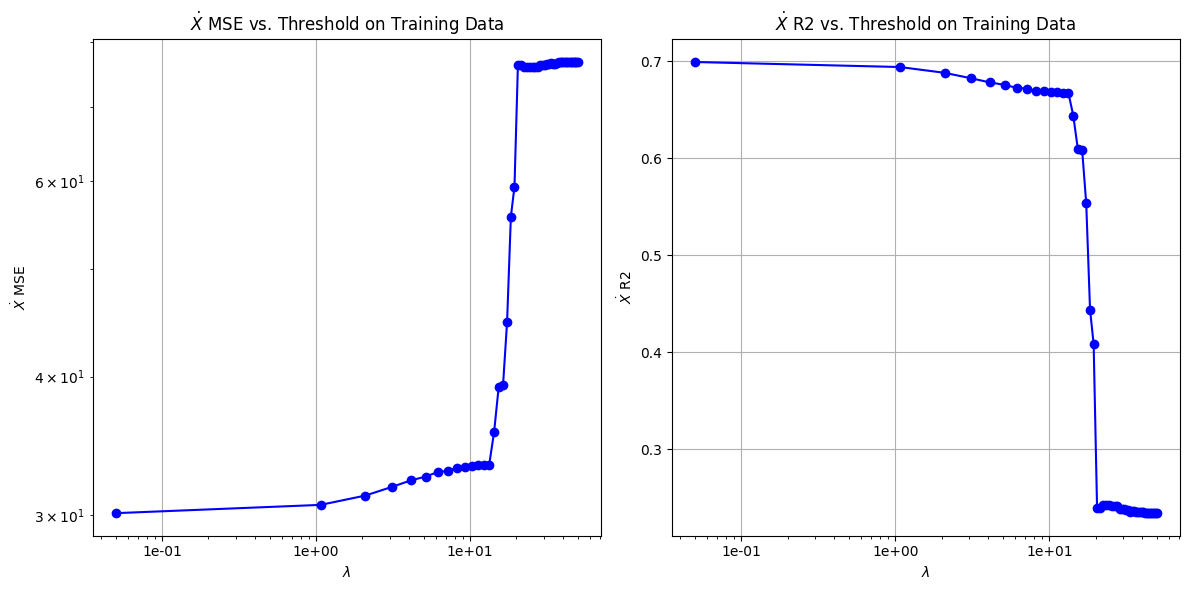

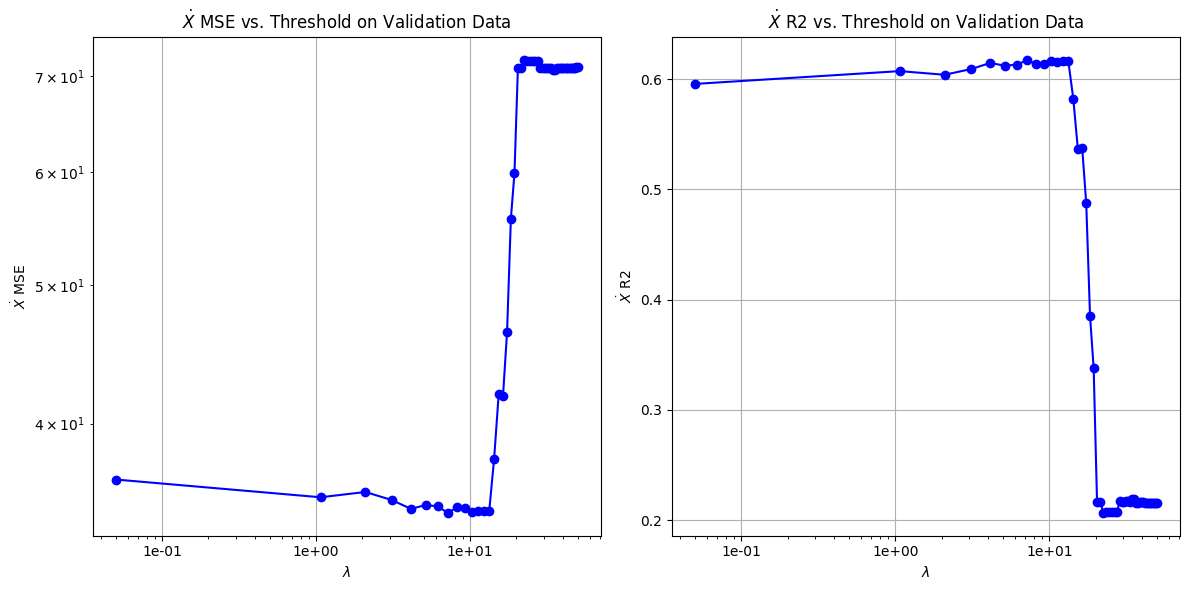

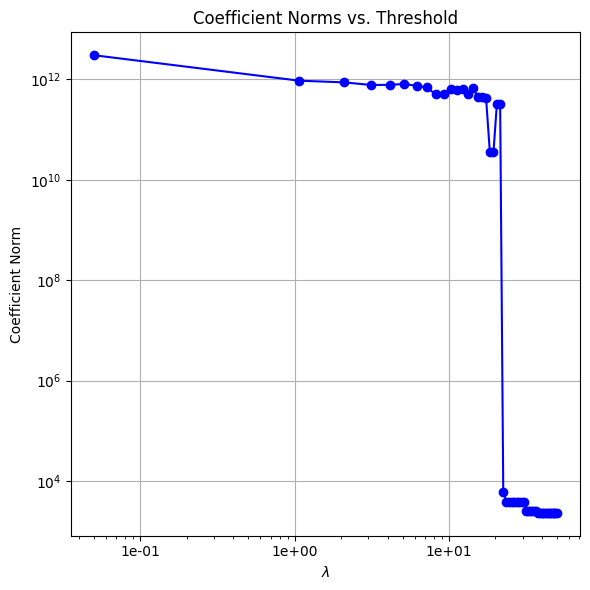


TRAINING on subjects '['sub_13', 'sub_4', 'sub_6', 'sub_7', 'sub_8', 'sub_9', 'sub_10', 'sub_11']', VALIDATION on subjects ['sub_12', 'sub_3']:
Best threshold: 7.1857e+00 | Coefficient norm: 6.8796e+11
	MSE [training]: 3.2892e+01	MSE [validation]: 3.4630e+01
	Adj. R2 [training]: 6.7186e-01	Adj. R2 [validation]: 6.1739e-01


In [7]:
if params['PERFORM_LAMBDA_TUNING']:
    # Define the threshold values to scan
    threshold_scan = np.linspace(params['LAMBDA_INF'], params['LAMBDA_SUP'], params['LAMBDA_NUM'])
    print(f'Thresholds to scan: {[f"{threshold:.4e}" for threshold in threshold_scan]}\n')

    ### SCAN THE THRESHOLD VALUES, FIT THE MODEL, AND EVALUATE THE PERFORMANCE ###
    coefficient_norms = []
    mse_train_array = []
    r2_train_array = []
    mse_test_array = []
    r2_test_array = []

    for iteration, threshold in enumerate(threshold_scan):
        # Define the optimizer
        if not params['ENABLE_ENSEMBLE_OPT']:
            optimizer = ps.STLSQ(threshold=threshold,
                                normalize_columns=params['NORMALIZE_COLUMNS'])
        else:
            optimizer = ps.EnsembleOptimizer(
                ps.STLSQ(threshold=threshold,
                        normalize_columns=params['NORMALIZE_COLUMNS']),
                bagging=params['ENSEMBLE_BAGGING'],
                n_subset=int(params['ENSEMBLE_SUBSAMPLING'] * num_training_samples)
            )

        # Define the SINDy model
        model = ps.SINDy(feature_names=feature_names,
                        feature_library=generalized_library,
                        optimizer=optimizer
        )

        # Fit the model
        model.fit(states_train_list,
                u=inputs_train_list,
                x_dot=states_deriv_train_list,
                t=time_train_list
        )
        
        # On 1st iteration only: Print the list of model feature names with their corresponding indices
        if threshold == threshold_scan[0]:
            print(f'\nModel feature names:')
            features = model.get_feature_names()
            for i, feature in enumerate(features):
                print(f'{i}: {feature}')

        # Get the coefficients
        if not params['ENABLE_ENSEMBLE_OPT']:
            coefficients = model.coefficients()
        else:
            ensemble_coefs = optimizer.coef_list # type: ignore
            coefficients = np.mean(ensemble_coefs, axis=0)
            std_ensemble = np.std(ensemble_coefs, axis=0)
        
        coefficient_norm = np.linalg.norm(coefficients)

        # Compute the number of coefficients whose absolute value is above the threshold (also the percentage)
        num_coeffs_sparse = np.sum(np.abs(coefficients) >= threshold)
        num_coeff_sparse_percent = (num_coeffs_sparse  * 100.0) / (coefficients.shape[0] * coefficients.shape[1])

        # Score the model (training)
        mse_train = model.score(states_train_list,
                                u=inputs_train_list,
                                x_dot=states_deriv_train_list,
                                metric=mean_squared_error
        )
        r2_score_train = model.score(states_train_list,
                                    u=inputs_train_list,
                                    x_dot=states_deriv_train_list,
                                    metric=adjusted_r2_score, # custom_r2_score,
                                    n_samples=num_training_datapoints,
                                    n_features=num_coeffs_sparse
        )

        # Score the model (validation)   
        mse_test = model.score(states_test_list,
                                u=inputs_test_list,
                                x_dot=states_deriv_test_list,
                                metric=mean_squared_error
        )
        r2_score_test = model.score(states_test_list,
                                    u=inputs_test_list,
                                    x_dot=states_deriv_test_list,
                                    metric=adjusted_r2_score, # custom_r2_score,
                                    n_samples=num_validation_datapoints,
                                    n_features=num_coeffs_sparse
        )

        # Print the results
        print(f"\n[iter {iteration+1} / {params['LAMBDA_NUM']}] => Threshold: {threshold:.4e}\n" \
                f' | # coeffs above threshold: {num_coeffs_sparse}' \
                f' | Percentage of coeffs kept: {num_coeff_sparse_percent:.2f}%' \
                f' | Coefficient norm: {coefficient_norm:.4e}\n' \
                f'\t# training datapoints: {num_training_datapoints}' \
                f'\t# validation datapoints: {num_validation_datapoints}\n' \
                f'\tMSE [training]: {mse_train:.4e}' \
                f'\tMSE [validation]: {mse_test:.4e}\n' \
                f'\tAdj. R2 [training]: {r2_score_train:.4e}' \
                f'\tAdj. R2 [validation]: {r2_score_test:.4e}')
        
        # Plot the sparsity pattern of the coefficients
        plot_coefficients_threshold(coefficients, feature_names, threshold=threshold)

        # Store the results
        coefficient_norms.append(coefficient_norm)
        mse_train_array.append(mse_train)
        r2_train_array.append(r2_score_train)
        mse_test_array.append(mse_test)
        r2_test_array.append(r2_score_test)


    # Check which model is the best on the validation set 
    best_idx = np.argmin(mse_test_array) # (evaluated based on the MSE)
    # best_idx = np.argmin(coefficient_norms) # (evaluated based on the coefficient norm)
    best_coeff_norm = coefficient_norms[best_idx]
    best_mse_test = mse_test_array[best_idx]
    best_r2_test = r2_test_array[best_idx]
    best_threshold_test = threshold_scan[best_idx]
    mse_train_for_best_test = mse_train_array[best_idx]
    r2_train_for_best_test = r2_train_array[best_idx]

    # Plot the Pareto front for the MSE and R2 in the training and validation set
    plot_pareto(threshold_scan, mse_train_array, r2_train_array, mse_test_array, r2_test_array, coefficient_norms)

    print(f"\nTRAINING on subjects '{params['TRAIN_SUBJECTS']}', VALIDATION on subjects {params['TEST_SUBJECTS']}:\n" \
            f'Best threshold: {best_threshold_test:.4e}' \
            f' | Coefficient norm: {best_coeff_norm:.4e}\n' \
            f'\tMSE [training]: {mse_train_for_best_test:.4e}' \
            f'\tMSE [validation]: {best_mse_test:.4e}\n' \
            f'\tAdj. R2 [training]: {r2_train_for_best_test:.4e}' \
            f'\tAdj. R2 [validation]: {best_r2_test:.4e}')

# Fit a model ensemble to improve SINDy performance

- Use the regularization threshold optimized with the procedure above
- Sample the entire time series with replacement with duplicates

See:
1. https://pysindy.readthedocs.io/en/stable/examples/1_feature_overview/example.html#Ensemble-methods
2. https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb

In [8]:
if params['PERFORM_LAMBDA_TUNING']:
    selected_threshold = best_threshold_test
else:
    selected_threshold = params['SELECTED_LAMBDA']

# Define the optimizer
if not params['ENABLE_ENSEMBLE_OPT']:
    optimizer = ps.STLSQ(threshold=selected_threshold,
                         normalize_columns=params['NORMALIZE_COLUMNS'])
else:
    optimizer = ps.EnsembleOptimizer(
        ps.STLSQ(threshold=selected_threshold,
                 normalize_columns=params['NORMALIZE_COLUMNS']),
        bagging=params['ENSEMBLE_BAGGING'],
        n_subset=int(params['ENSEMBLE_SUBSAMPLING'] * num_training_samples)
    )

# Define the SINDy model
model = ps.SINDy(feature_names=feature_names,
                 feature_library=generalized_library,
                 optimizer=optimizer
)

# Fit the model
model.fit(states_train_list,
          u=inputs_train_list,
          x_dot=states_deriv_train_list,
          t=time_train_list
)

# Save the model
n_saved_models = int(len(os.listdir(models_dir)) / 2)
with open(os.path.join(models_dir, f"sindy_model_{n_saved_models}.pkl"), 'wb') as f:
    dill.dump(model, f)
print(f"Model saved to 'sindy_model_{n_saved_models}.pkl'")

# Save the params used to train the model
with open(os.path.join(models_dir, f"params_sindy_model_{n_saved_models}.json"), 'w') as f:
    json.dump(params, f, indent=4)
print(f"Parameters saved to 'params_sindy_model_{n_saved_models}.json'")

Model saved to 'sindy_model_9.pkl'
Parameters saved to 'params_sindy_model_9.json'


# Extract Model Coefficients

In [9]:
# Get the number of states and controls
model_states = model.n_features_in_
model_controls = model.n_control_features_
model_outputs = model.n_output_features_

print(f'\nModel states: {model_states}')
print(f'Model controls: {model_controls}')
print(f'Model outputs: {model_outputs}')

# Get the feature names
features = model.get_feature_names()
for i, feature in enumerate(features):
    print(f'{i}: {feature}')
    
# Get the coefficients
if not params['ENABLE_ENSEMBLE_OPT']:
    coefficients = model.coefficients()
else:
    ensemble_coefs = optimizer.coef_list # type: ignore
    coefficients = np.mean(ensemble_coefs, axis=0)
    coefficients_std = np.std(ensemble_coefs, axis=0)

# Plot the sparsity pattern of the coefficients
plot_coefficients_threshold(coefficients, feature_names, threshold=selected_threshold)

if params['ENABLE_ENSEMBLE_OPT']:
    # Plot the standard deviation of the coefficients
    plot_coefficients_threshold(coefficients_std, feature_names, threshold=0.0) # CHECK


Model states: 51
Model controls: 36
Model outputs: 154
0: 1
1: ddq_chest_rot_x
2: ddq_chest_rot_y
3: ddq_chest_rot_z
4: ddq_chest_rot_w
5: ddq_shoulder_rot_x
6: ddq_right_arm_rot_z
7: ddq_right_arm_rot_x
8: ddq_right_arm_rot_y
9: ddq_right_elbow_rot_z
10: ddq_left_arm_rot_z
11: ddq_left_arm_rot_x
12: ddq_left_arm_rot_y
13: ddq_left_elbow_rot_z
14: ddq_head_rot_z
15: ddq_head_rot_x
16: filt_q_chest_rot_x
17: filt_q_chest_rot_y
18: filt_q_chest_rot_z
19: filt_q_chest_rot_w
20: filt_q_shoulder_rot_x
21: filt_q_right_arm_rot_z
22: filt_q_right_arm_rot_x
23: filt_q_right_arm_rot_y
24: filt_q_right_elbow_rot_z
25: filt_q_left_arm_rot_z
26: filt_q_left_arm_rot_x
27: filt_q_left_arm_rot_y
28: filt_q_left_elbow_rot_z
29: filt_q_head_rot_z
30: filt_q_head_rot_x
31: dq_chest_rot_x
32: dq_chest_rot_y
33: dq_chest_rot_z
34: dq_chest_rot_w
35: dq_shoulder_rot_x
36: dq_right_arm_rot_z
37: dq_right_arm_rot_x
38: dq_right_arm_rot_y
39: dq_right_elbow_rot_z
40: dq_left_arm_rot_z
41: dq_left_arm_rot_x
4

# Score the model

In [10]:
# Compute the number of coefficients whose absolute value is above the threshold (also the percentage)
num_coeffs_sparse = np.sum(np.abs(coefficients) >= selected_threshold)
num_coeff_sparse_percent = num_coeffs_sparse / (coefficients.shape[0] * coefficients.shape[1]) * 100

coefficient_norm = np.linalg.norm(coefficients)

# Score the model (training)
mse_train = model.score(states_train_list,
                        u=inputs_train_list,
                        x_dot=states_deriv_train_list,
                        metric=mean_squared_error
)
r2_score_train = model.score(states_train_list,
                             u=inputs_train_list,
                             x_dot=states_deriv_train_list,
                             metric=adjusted_r2_score, # custom_r2_score,
                             n_samples=num_training_datapoints,
                             n_features=num_coeffs_sparse
)

# Score the model (validation)
mse_test = model.score(states_test_list,
                        u=inputs_test_list,
                        x_dot=states_deriv_test_list,
                        metric=mean_squared_error
)
r2_score_test = model.score(states_test_list,
                            u=inputs_test_list,
                            x_dot=states_deriv_test_list,
                            metric=adjusted_r2_score, # custom_r2_score,
                            n_samples=num_validation_datapoints,
                            n_features=num_coeffs_sparse
)

# Print the results
print(f'Threshold: {selected_threshold:.4e}' \
      f' | # coeffs above threshold: {num_coeffs_sparse}' \
      f' | Percentage of coeffs kept: {num_coeff_sparse_percent:.0f}%' \
      f' | Coefficient norm: {coefficient_norm:.4e}\n' \
      f'\t# training datapoints: {num_training_datapoints}' \
      f'\t\t# validation datapoints: {num_validation_datapoints}\n' \
      f'\tMSE [training]: {mse_train:.4e}' \
      f'\t\tMSE [validation]: {mse_test:.4e}\n' \
      f'\tAdj. R2 [training]: {r2_score_train:.4e}' \
      f'\t\tAdj. R2 [validation]: {r2_score_test:.4e}')

Threshold: 7.1857e+00 | # coeffs above threshold: 308 | Percentage of coeffs kept: 13% | Coefficient norm: 6.8796e+11
	# training datapoints: 8016129		# validation datapoints: 1731348
	MSE [training]: 3.2892e+01		MSE [validation]: 3.4630e+01
	Adj. R2 [training]: 6.7186e-01		Adj. R2 [validation]: 6.1739e-01


# Predict derivatives with the learned model

In [11]:
states_deriv_pred_list = []
for traj, input, t in zip(states_test_list, inputs_test_list, time_test_list):
    print(traj.shape, input.shape)
    states_deriv_pred = model.predict(traj, u=input)
    states_deriv_pred_list.append(states_deriv_pred)

(953, 15) (953, 36)
(606, 15) (606, 36)
(366, 15) (366, 36)
(936, 15) (936, 36)
(700, 15) (700, 36)
(342, 15) (342, 36)
(1020, 15) (1020, 36)
(649, 15) (649, 36)
(328, 15) (328, 36)
(958, 15) (958, 36)
(689, 15) (689, 36)
(354, 15) (354, 36)
(967, 15) (967, 36)
(642, 15) (642, 36)
(365, 15) (365, 36)
(1002, 15) (1002, 36)
(653, 15) (653, 36)
(344, 15) (344, 36)
(907, 15) (907, 36)
(661, 15) (661, 36)
(341, 15) (341, 36)
(963, 15) (963, 36)
(619, 15) (619, 36)
(361, 15) (361, 36)
(1740, 15) (1740, 36)
(1392, 15) (1392, 36)
(1095, 15) (1095, 36)
(702, 15) (702, 36)
(501, 15) (501, 36)
(298, 15) (298, 36)
(706, 15) (706, 36)
(503, 15) (503, 36)
(300, 15) (300, 36)
(706, 15) (706, 36)
(503, 15) (503, 36)
(293, 15) (293, 36)
(478, 15) (478, 36)
(363, 15) (363, 36)
(299, 15) (299, 36)
(496, 15) (496, 36)
(355, 15) (355, 36)
(294, 15) (294, 36)
(706, 15) (706, 36)
(498, 15) (498, 36)
(298, 15) (298, 36)
(706, 15) (706, 36)
(504, 15) (504, 36)
(299, 15) (299, 36)
(707, 15) (707, 36)
(504, 15) 

# Simulate the model forward in time to predict future states

In [12]:
# print("All simulations completed")
from scipy.integrate import solve_ivp

def sindy_model(t, y, input, deriv_dict):
    # Find the two closest keys around the given t
    keys = np.array(list(deriv_dict.keys()))
    idx = np.searchsorted(keys, t)
    
    if idx == 0:
        t0, t1 = keys[0], keys[1]
    elif idx == len(keys):
        t0, t1 = keys[-2], keys[-1]
    else:
        t0, t1 = keys[idx - 1], keys[idx]
    
    # Interpolate between the corresponding values
    deriv0, deriv1 = deriv_dict[t0], deriv_dict[t1]
    interpolated_deriv = deriv0 + (deriv1 - deriv0) * (t - t0) / (t1 - t0)

    return interpolated_deriv

states_pred_list = []
for i in range(len(states_test_list)):
    traj = states_test_list[i]
    input = inputs_test_list[i]
    t = time_test_list[i]
    deriv = states_deriv_pred_list[i]

    # Create a dictionary where keys are elements of t and values are elements of deriv
    deriv_dict = {t[j]: deriv[j] for j in range(len(t))}

    states_pred = solve_ivp(sindy_model, [t[0], t[-1]], traj[0], t_eval=t, args=(input, deriv_dict,))
    states_pred_list.append(states_pred.y.T)

In [13]:
# Select which state derivative to plot
derivative_to_plot = 'ddq_left_elbow_rot_z' # change according to the states selected in the params.yaml file
plot_idx = np.where(np.array(state_names) == derivative_to_plot)[0][0]

sub_to_plot = params['TEST_SUBJECTS'][0]
vel_to_plot = 'MEDIUM' # change according to the velocities selected in the params.yaml file
instr_to_plot = 1 # change according to the instructions selected in the params.yaml file

# Retrieve the data for the selected trajectory
traj_to_plot = [i for i, traj in enumerate(test_traj_idx)
                if traj['subject'] == sub_to_plot
                    and traj['instruction'] == instr_to_plot
                    and traj['velocity'] == vel_to_plot
               ][0] # find the trajectory index

states_deriv_pred = states_deriv_pred_list[traj_to_plot]
states_deriv_true = states_deriv_test_list[traj_to_plot]

states_pred = states_pred_list[traj_to_plot]
states_true = states_test_list[traj_to_plot]

# Plot the predicted vs. true derivatives
fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_deriv_pred[:, plot_idx],
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_deriv_true[:, plot_idx],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
    
fig.update_layout(title=f'Predicted vs. True State Derivative: {derivative_to_plot}',
                  xaxis_title='Time [s]',
                  yaxis_title='Derivative',
                  showlegend=True
)

fig.show()

# Plot the predicted vs. true states
fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_pred[:, plot_idx],
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=states_true[:, plot_idx],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True State: {derivative_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='State',
                    showlegend=True
    )

fig.show()

# Integrate the state (joint acceleration) to get velocity and position

In [14]:
# Integrate the predicted accelerations to get the velocities
joint_vel_pred_list = []
for i in range(len(states_pred_list)):
    states_pred = states_pred_list[i]
    t = time_test_list[i]

    joint_vel_pred = np.zeros(states_pred.shape)
    for j in range(states_pred.shape[1]):
        joint_vel_pred[:, j] = np.cumsum(states_pred[:, j]) * np.mean(np.diff(t))

    joint_vel_pred_list.append(joint_vel_pred)

# Integrate the predicted velocities to get the positions
joint_pos_pred_list = []
for i in range(len(joint_vel_pred_list)):
    joint_vel_pred = joint_vel_pred_list[i]
    t = time_test_list[i]

    joint_pos_pred = np.zeros(joint_vel_pred.shape)
    for j in range(joint_vel_pred.shape[1]):
        joint_pos_pred[:, j] = np.cumsum(joint_vel_pred[:, j]) * np.mean(np.diff(t))

    joint_pos_pred_list.append(joint_pos_pred)

In [15]:
# Select which joint position/velocity to plot
joint_pos_to_plot = derivative_to_plot.replace('ddq', 'filt_q')
joint_vel_to_plot = derivative_to_plot.replace('ddq', 'dq')

plot_idx_pred = np.where(np.array(state_names) == derivative_to_plot)[0][0]
plot_idx_pos = np.where(np.array(control_names) == joint_pos_to_plot)[0][0]
plot_idx_vel = np.where(np.array(control_names) == joint_vel_to_plot)[0][0]

# Retrieve the data for the selected trajectory
traj_to_plot = [i for i, traj in enumerate(test_traj_idx)
                if traj['subject'] == sub_to_plot
                    and traj['instruction'] == instr_to_plot
                    and traj['velocity'] == vel_to_plot
               ][0] # find the trajectory index

joint_vel_pred = joint_vel_pred_list[traj_to_plot]
joint_pos_pred = joint_pos_pred_list[traj_to_plot]
joint_true = inputs_test_list[traj_to_plot]

# Plot the predicted vs. true joint velocities
v0 = joint_true[0, plot_idx_vel]

fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_vel_pred[:, plot_idx_pred] + v0,
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_true[:, plot_idx_vel],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True Joint Velocity: {joint_vel_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='Velocity',
                    showlegend=True
)

fig.show()

# Plot the predicted vs. true joint positions
y0 = joint_true[0, plot_idx_pos]

fig = go.Figure()
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_pos_pred[:, plot_idx_pred] + y0,
                    mode='lines',
                    line=dict(color='blue', width=1),
                    name=f'Prediction ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)
fig.add_trace(go.Scatter
                (x=time_test_list[traj_to_plot],
                    y=joint_true[:, plot_idx_pos],
                    mode='lines',
                    line=dict(color='red', width=1),
                    name=f'True ({sub_to_plot}, {instr_to_plot}, {vel_to_plot})'
                )
)

fig.update_layout(title=f'Predicted vs. True Joint Position: {joint_pos_to_plot}',
                    xaxis_title='Time [s]',
                    yaxis_title='Position',
                    showlegend=True
)

fig.show()